# Advanced Backend API Testing and Comprehensive Data Analysis

This Jupyter Notebook extensively tests and analyzes the REST API built with NestJS and its integration with multiple databases:

- **PostgreSQL** (relational data: users, groups)
- **Cassandra** (messages, notifications)
- **Redis** (cache performance)
- **Neo4j** (user relationships)
- **Storage Bucket** (file uploads)

### Objectives:
- Verify database connectivity and API responses.
- Generate and validate fake data.
- Perform detailed performance analysis.
- Confirm integration across all databases.

# python 3.10.16 used

In [41]:
# Install required libraries
%pip install requests pandas matplotlib seaborn faker psycopg2-binary neo4j redis boto3
%pip install cassandra-driver --no-binary cassandra-driver


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
# Logging configuration for better debug and traceability
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [43]:
# Import libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
import time
import psycopg2
from cassandra.cluster import Cluster
from neo4j import GraphDatabase
import redis
import boto3

fake = Faker()

## Backend setup (Terminal)

```bash
npm run start:dev
```

In [44]:
# Define API base and endpoints
API_BASE = "http://localhost:3000"

ENDPOINTS = {
    "users": f"{API_BASE}/users",
    "messages": f"{API_BASE}/messages",
    "cache": f"{API_BASE}/cache",
    "relationships": f"{API_BASE}/relationships",
    "files": f"{API_BASE}/files",
    "storage_test": f"{API_BASE}/storage/test.txt"
}


## Database Settings

In [45]:
# Database configurations
POSTGRES_SETTINGS = {
    'host': 'localhost',
    'port': 5432,
    'user': 'postgres',
    'password': 'postgres',
    'database': 'mydb'
}
CASSANDRA_SETTINGS = {
    'host': ['localhost'],  # ou 'host.docker.internal' si besoin
    'port': 9042
}
NEO4J_SETTINGS = {
    'uri': 'bolt://localhost:7687',
    'auth': ("neo4j", "neo4jazerty")
}
REDIS_SETTINGS = {
    'host': 'localhost',
    'port': 6379,
    'db': 0
}
STORAGE_SETTINGS = {
    'endpoint': 'http://localhost:9000',
    'access_key': 'minioadmin',
    'secret_key': 'minioadmin',
    'bucket': 'uploads'
}


# Verifying database connections

In [46]:
# PostgreSQL Check
try:
    conn_pg = psycopg2.connect(**POSTGRES_SETTINGS)
    cur_pg = conn_pg.cursor()
    cur_pg.execute('SELECT COUNT(*) FROM "users";')
    logging.info(f"PostgreSQL Users: {cur_pg.fetchone()[0]}")
    cur_pg.close()
    conn_pg.close()
except Exception as e:
    logging.error(f"PostgreSQL Error: {e}")

# Cassandra Check
try:
    cluster_cass = Cluster(CASSANDRA_SETTINGS['host'], port=CASSANDRA_SETTINGS['port'])
    session_cass = cluster_cass.connect('summertrip')
    rows = session_cass.execute('SELECT COUNT(*) FROM messages;')
    logging.info(f"Cassandra Messages: {rows.one()[0]}")
except Exception as e:
    logging.error(f"Cassandra Error: {e}")

# Redis Check
try:
    redis_client = redis.Redis(**REDIS_SETTINGS)
    redis_client.set('test', 'Redis OK')
    logging.info(f"Redis Check: {redis_client.get('test').decode()}")
except Exception as e:
    logging.error(f"Redis Error: {e}")

# Neo4j Check
try:
    driver_neo4j = GraphDatabase.driver(**NEO4J_SETTINGS)
    with driver_neo4j.session() as session:
        result = session.run('MATCH (n) RETURN COUNT(n) AS count')
        logging.info(f"Neo4j Nodes: {result.single()['count']}")
    driver_neo4j.close()
except Exception as e:
    logging.error(f"Neo4j Error: {e}")

# Storage Check
try:
    s3_client = boto3.client(
        's3',
        endpoint_url=STORAGE_SETTINGS['endpoint'],
        aws_access_key_id=STORAGE_SETTINGS['access_key'],
        aws_secret_access_key=STORAGE_SETTINGS['secret_key']
    )
    s3_client.put_object(Bucket=STORAGE_SETTINGS['bucket'], Key='test.txt', Body=b'Test file')
    response = s3_client.get_object(Bucket=STORAGE_SETTINGS['bucket'], Key='test.txt')
    logging.info(f"Storage Bucket Content: {response['Body'].read().decode()}")
except Exception as e:
    logging.error(f"Storage Bucket Error: {e}")


2025-04-07 11:48:43,887 - INFO - PostgreSQL Users: 100
2025-04-07 11:48:43,890 - WARNING - Cluster.__init__ called with contact_points specified, but no load_balancing_policy. In the next major version, this will raise an error; please specify a load-balancing policy. (contact_points = ['localhost'], lbp = None)
2025-04-07 11:48:45,152 - WARNING - Downgrading core protocol version from 66 to 65 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
2025-04-07 11:48:46,670 - WARNING - Downgrading core protocol version from 65 to 5 for 127.0.0.1:9042. To avoid this, it is best practice to explicitly set Cluster(protocol_version) to the version supported by your cluster. http://datastax.github.io/python-driver/api/cassandra/cluster.html#cassandra.cluster.Cluster.protocol_version
2025-04-07 11:48:

## Performance Testing : 

In [47]:
def benchmark_endpoint(url: str, label: str = "Endpoint", n: int = 100):
    """
    Benchmarks an API GET endpoint by measuring response time over n requests.
    Displays histogram and basic statistics.
    """
    times = []
    for _ in range(n):
        start = time.time()
        try:
            requests.get(url)
        except Exception as e:
            logging.warning(f"Request to {url} failed: {e}")
            continue
        times.append(time.time() - start)

    if not times:
        print(f"No successful requests for {label}.")
        return []

    # Plot histogram
    sns.histplot(times, kde=True)
    plt.title(f'{label} Response Time')
    plt.xlabel('Seconds')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Print stats
    print(f"{label} - Average: {round(sum(times)/len(times), 4)}s | Max: {round(max(times), 4)}s | Min: {round(min(times), 4)}s")

    return times


### PostgreSQL

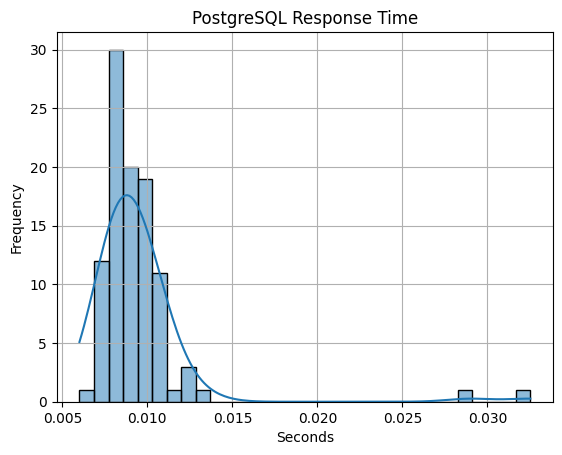

PostgreSQL - Average: 0.0095s | Max: 0.0325s | Min: 0.006s


In [48]:
times_pg = benchmark_endpoint(f'{API_BASE}/users', "PostgreSQL")


### Cassandra

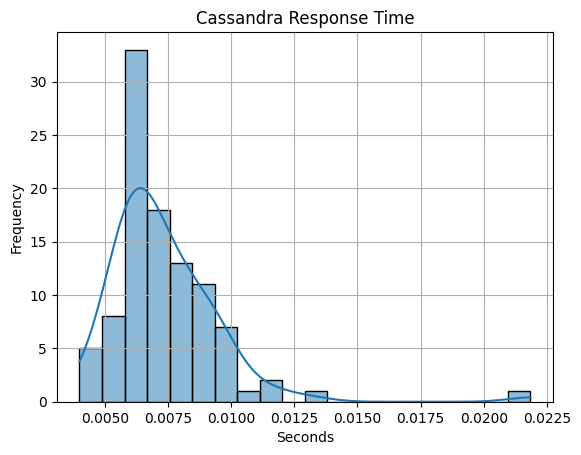

Cassandra - Average: 0.0074s | Max: 0.0218s | Min: 0.004s


In [49]:

times_cass = benchmark_endpoint(f'{API_BASE}/messages', "Cassandra")

### Redis

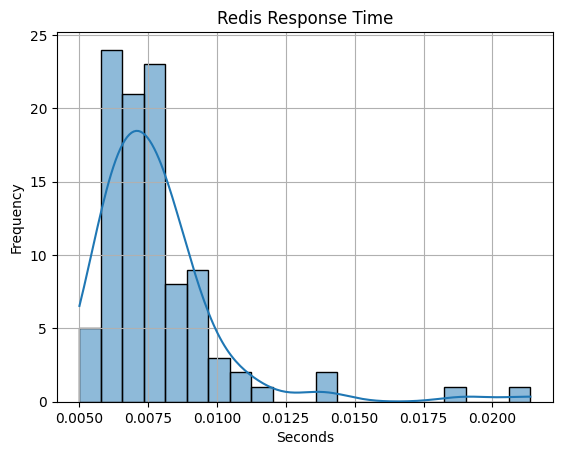

Redis - Average: 0.0078s | Max: 0.0214s | Min: 0.005s


In [50]:

times_redis = benchmark_endpoint(f'{API_BASE}/cache', "Redis")

### Neo4j

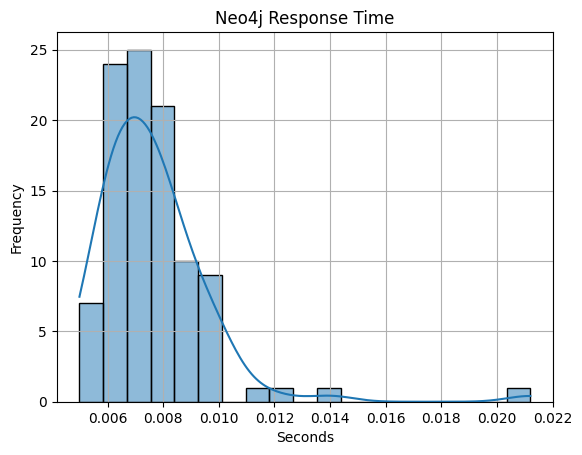

Neo4j - Average: 0.0076s | Max: 0.0212s | Min: 0.005s


In [51]:

times_neo4j = benchmark_endpoint(f'{API_BASE}/relationships', "Neo4j")

### Storage

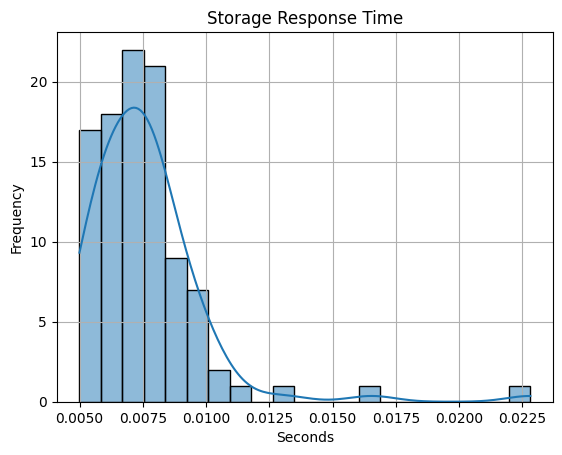

Storage - Average: 0.0076s | Max: 0.0228s | Min: 0.005s


In [52]:

times_storage = benchmark_endpoint(f'{API_BASE}/storage/test.txt', "Storage")

## Fake Data Generation

### Cassandra

In [53]:
# Add fake messages
for _ in range(50):
    requests.post(f'{API_BASE}/messages',json={
        'sender_id':fake.uuid4(),
        'receiver_id':fake.uuid4(),
        'content':fake.text()
    })
print('Added 50 messages.')

Added 50 messages.


### Redis

In [54]:
# Add fake cache entries
for _ in range(50):
    requests.post(f'{API_BASE}/cache',json={
        'key':fake.uuid4(),
        'value':fake.text()
    })
print('Added 50 cache entries.')

Added 50 cache entries.


### Neo4j

In [55]:
# Add fake relationships
for _ in range(50):
    requests.post(f'{API_BASE}/relationships',json={
        'user1_id':fake.uuid4(),
        'user2_id':fake.uuid4(),
        'type':fake.random_element(elements=('friend', 'colleague', 'family'))
    })
print('Added 50 relationships.')

Added 50 relationships.


### Storage

In [56]:
# Add fake files
for _ in range(50):
    requests.post(f'{API_BASE}/files',files={'file':('test.txt',fake.text())})
print('Added 50 files.')

Added 50 files.


## Global performance comparison


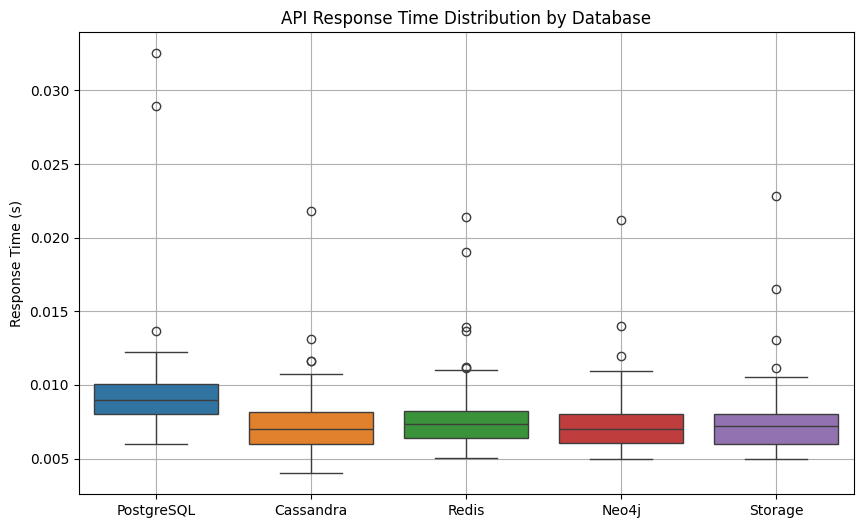

In [57]:
performance_summary = {
    "PostgreSQL": times_pg,
    "Cassandra": times_cass,
    "Redis": times_redis,
    "Neo4j": times_neo4j,
    "Storage": times_storage
}

df_perf = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in performance_summary.items()]))

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_perf)
plt.title("API Response Time Distribution by Database")
plt.ylabel("Response Time (s)")
plt.grid(True)
plt.show()


## Data Analysis


### Display sample users from PostgreSQL

In [58]:

try:
    conn_pg = psycopg2.connect(**POSTGRES_SETTINGS)
    df_users = pd.read_sql("SELECT * FROM users LIMIT 10;", conn_pg)
    display(df_users)
    conn_pg.close()
except Exception as e:
    logging.error(f"Error reading users table from PostgreSQL: {e}")


C:\Users\nolan\AppData\Local\Temp\ipykernel_3304\96360641.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_users = pd.read_sql("SELECT * FROM users LIMIT 10;", conn_pg)


,id,firstName,lastName,email,password
0,1,Jailyn,Deckow,Loyce_Zieme98@yahoo.com,AjKofUmlVBsmPAU
1,2,Felicity,Lueilwitz,Janessa.Gutkowski@hotmail.com,j_Xd1G44VkiUWAY
2,3,None,Medhurst,Fermin.Morar77@gmail.com,uDH3nFNZbLE72hJ
3,4,Emma,None,Maryjane.Effertz@hotmail.com,WoYoDcAwWzPG9hU
4,5,None,Hoppe,Easton_Tillman@hotmail.com,tBYc5etZIXdVm3b
5,6,None,None,Reina66@gmail.com,GdntZriLvTXzOsM
6,7,None,Spinka,Samson24@gmail.com,NUs72DSOyOB54Bi
7,8,Chelsey,Turcotte,Hermina28@gmail.com,LwRGvT0cDObCsJh
8,9,Kirk,Sawayn,Erin_Mitchell@gmail.com,JKj2Si6DqFSIInG
9,10,Adaline,Leuschke,Leonie.Daugherty26@hotmail.com,0HfakbnoAP7goTu


### Display sample users from Cassandra

In [59]:

try:
    rows = session_cass.execute("SELECT * FROM messages LIMIT 10;")
    df_messages = pd.DataFrame(rows.all())
    display(df_messages)
except Exception as e:
    logging.error(f"Error reading messages from Cassandra: {e}")


,conversation_id,message_id,content,created_at,sender_id
0,6c74b171-1726-49c4-8cf2-bca1115386a2,29c5800c-2723-4821-97f3-1616ce3b9af7,Substantia demo complectus via acies aurum com...,2025-03-27 19:02:48.258,3
1,76674703-b295-413f-b5f0-01c42d9a172a,9f0824d3-b15a-49e2-9783-cc98d3fedebc,Derelinquo careo sublime aperiam talio nemo.,2025-03-27 18:57:19.117,58
2,4b723e11-9eb7-4b0e-9724-14d95c97ac29,3884b981-0624-4172-aac9-9f49a7ad1aa5,Accusantium pax urbanus.,2025-03-27 19:37:59.135,96
3,a6643acb-0abf-4c8a-8946-8ecf28d0b7b1,cac8fade-ad57-49f9-9a15-b7d3dc445038,Astrum soleo clamo apparatus vestigium tenax t...,2025-03-27 18:57:19.042,63
4,fd2e20f8-04b6-4bb7-9b82-f573e98aac08,daee56d6-b071-4c43-af89-c2ffc9ab20be,Sui stillicidium eaque cunctatio defungo.,2025-03-27 19:22:10.569,42
5,207b9cc4-8e07-4a2d-bfa2-473c87418b62,24b3406b-6d43-4343-835c-a9ecec92a833,Teres volo arbitro pauci vinum.,2025-03-27 18:57:18.978,100
6,183f136c-4da9-48e6-b82e-562810fc77a1,59438f74-2bfa-4e59-8a4e-c451b804aac6,Pauper volaticus vaco civitas thema vinum subl...,2025-03-27 19:22:10.630,54
7,e1fc8e6e-1c2d-4ae7-843d-1afb1957a848,8ba39d8c-083e-4a8a-a640-673d3744af46,Termes sono mollitia modi balbus conspergo tes...,2025-03-27 19:02:48.159,42
8,a0846703-52aa-446f-81b4-2c6fb8d9995f,ec512617-c5bc-4fed-b9ac-7af33f97e39a,Basium arca territo calculus defleo arca convo...,2025-03-27 19:37:59.143,39
9,2c60feb1-f978-405c-95d0-2b595f486419,0d02bc45-f8af-49d0-98a7-8a37b149e901,Sunt teneo tamdiu calculus adicio corrupti ter...,2025-03-27 19:22:10.635,81


### Analyze message content length (from Cassandra)

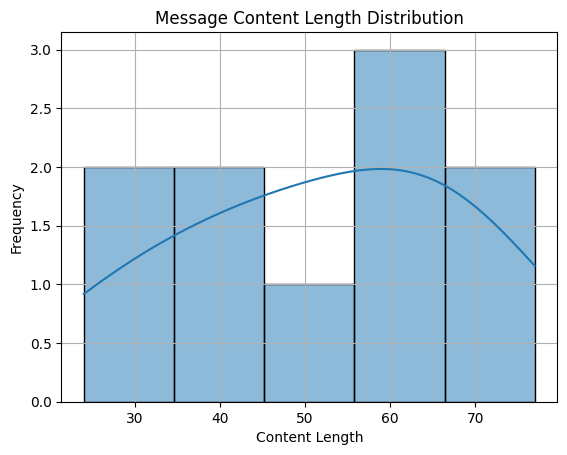

In [60]:

if 'df_messages' in globals() and not df_messages.empty and "content" in df_messages.columns:
    df_messages["content_length"] = df_messages["content"].apply(lambda x: len(str(x)))
    sns.histplot(df_messages["content_length"], kde=True)
    plt.title("Message Content Length Distribution")
    plt.xlabel("Content Length")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


### Display sample relationships from Neo4j

In [61]:

try:
    with driver_neo4j.session() as session:
        query = '''
        MATCH (a)-[r]->(b)
        RETURN a.id AS user1, type(r) AS relationship, b.id AS user2
        LIMIT 10
        '''
        result = session.run(query)
        df_rel = pd.DataFrame([r.data() for r in result])
        display(df_rel)
except Exception as e:
    logging.error(f"Error reading relationships from Neo4j: {e}")


C:\Users\nolan\AppData\Local\Temp\ipykernel_3304\1538886511.py:2: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver_neo4j.session() as session:


,user1,relationship,user2
0,8.0,FRIEND,35.0
1,92.0,FRIEND,26.0
2,52.0,FRIEND,57.0
3,19.0,FRIEND,56.0
4,27.0,FRIEND,15.0
5,83.0,FRIEND,27.0
6,77.0,FRIEND,9.0
7,16.0,FRIEND,19.0
8,96.0,FRIEND,78.0
9,71.0,FRIEND,25.0


### Display sample files from the storage bucket (MinIO)

In [62]:

try:
    objects = s3_client.list_objects_v2(Bucket=STORAGE_SETTINGS["bucket"])
    df_files = pd.DataFrame(objects.get("Contents", []))  # fallback in case it's empty
    display(df_files[["Key", "LastModified", "Size"]].head(10))
except Exception as e:
    logging.error(f"Error listing objects from Storage Bucket: {e}")


,Key,LastModified,Size
0,test.txt,2025-04-07 09:48:49.832000+00:00,9


# Close all database connections after testing

In [63]:
session_cass.shutdown()
cluster_cass.shutdown()
redis_client.close()